### References
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/soumith/ganhacks

In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
import torchvision.utils as vutils
import random
from torch.utils.data.dataset import random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms.functional import convert_image_dtype

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NZ = 256        # Размер векторра шума z
NGF = 32        # Размер модификатора каналов в генераторе
NDF = 32        # Размер модификатора каналов в дискриминаторе
NC = 3          # Количество каналов в изображении
BETA_1 = 0.5    # B1 коэффициент оптимизатора
CLASS_N = 11    # Количество классов в датасете

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: NZ
            nn.ConvTranspose2d(NZ, NGF * 12, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 12),
            nn.ReLU(True),
            # ngf*12 x 4 x 4 
            nn.ConvTranspose2d(NGF * 12, NGF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # ngf*8 x 8 x 8 
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # ngf*4 x 16 x 16
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # ngf*2 x 32 x 32
            nn.ConvTranspose2d(NGF * 2, NGF , 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # ngf x 64 x 64
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
            # nc x 128 x 128
        )

    def forward(self, x, rnd=0.005):
        x = self.main(x)
        noise = (rnd**0.5)*torch.randn(x.shape, device=DEVICE).detach()
        return x + noise

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: nc x 128 x 128
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 64 x 64
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 32 x 32
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 16 x 16
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 4 x 4
        )

        self.image_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, CLASS_N, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fake_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        fake = self.fake_classification(x)
        label = self.image_classification(x)
        return fake, label

In [5]:
def train(models, data_loader: DataLoader, optimizers: tuple, loss_fn, class_loss_fn, rnd=0.005):
    D, G = models
    G.train()
    D.train()

    d_optim, g_optim = optimizers
    train_d_loss, train_g_loss = 0, 0

    for real_img, class_label in data_loader:
        real_img, class_label = real_img.to(DEVICE), class_label.to(DEVICE)
        batch_size = real_img.size(0)

        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE), rnd)

        # добавляем шум в входные данные
        real_img = real_img + (rnd**0.5)*torch.randn(real_img.shape, device=DEVICE).detach()
       
        # тренируем дискриминатор
        d_optim.zero_grad()
        # реальные изображения
        true_outs, label = D(real_img)
        d_real_loss = loss_fn(true_outs, torch.ones_like(true_outs, device=DEVICE).uniform_(0.9, 0.9))
        d_real_loss = d_real_loss + class_loss_fn(label.squeeze(2, 3), class_label)
        d_real_loss.backward()

        # фейковые изображения
        fake_outs, _ = D(fake_img.detach())
        d_fake_img_loss = loss_fn(fake_outs, torch.zeros_like(fake_outs, device=DEVICE))
        d_fake_img_loss.backward()  
        d_optim.step()
        
        # тренируем генератор
        g_optim.zero_grad()
        fake_outs_, _ = D(fake_img)
        g_loss = loss_fn(fake_outs_, torch.ones_like(fake_outs_, device=DEVICE).uniform_(0.9, 0.9))
        g_loss.backward()
        g_optim.step()

        train_d_loss += (d_real_loss + d_fake_img_loss).item()
        train_g_loss += g_loss.item()

    train_g_loss /= len(data_loader)
    train_d_loss /= len(data_loader)

    return train_d_loss, train_g_loss

In [6]:
@torch.no_grad()
def rescale(tensor):
    tensor -= tensor.min() 
    tensor /= tensor.max() 
    return tensor

@torch.no_grad()
def eval(model, data_loader, fid):
    G = model
    G.to(DEVICE)
    G.eval()

    for real_img, _ in data_loader:
        real_img = real_img.to(DEVICE)
        batch_size = real_img.size(0)
        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE))

        fid.update(convert_image_dtype(rescale(real_img), torch.uint8), real=True)
        fid.update(convert_image_dtype(rescale(fake_img), torch.uint8), real=False)

    score = fid.compute()
    fid.reset()
    return score

In [14]:
image_dataset = ImageFolder(
    root='planets\\',
    transform=T.Compose([
        T.Resize(128),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

train_data , eval_data = random_split(image_dataset, (int(len(image_dataset) * 0.9), len(image_dataset) - int(len(image_dataset) * 0.9)))
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = torch.utils.data.DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

G.to(DEVICE)
D.to(DEVICE)

g_optim = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss()
fid = FrechetInceptionDistance(feature=2048, reset_real_features=False).to(DEVICE)

In [9]:
fix_noise = torch.randn(16, NZ, 1, 1, device=DEVICE)


def plot_examples(title=None):
    G.eval()
    D.eval()

    plt.figure(figsize=(10, 4))
    images = G(fix_noise)

    plt.imshow(np.transpose(vutils.make_grid(images.cpu(), padding=5, normalize=True), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

In [10]:
def change_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

epoch:1, d loss:2.587869071960449, g loss:3.3279571354389192, fid:428.682861328125
epoch:2, d loss:2.155449640750885, g loss:4.677524316310882, fid:369.84124755859375
epoch:3, d loss:2.2302112102508547, g loss:6.146284067630768, fid:324.42047119140625
epoch:4, d loss:2.03629931807518, g loss:5.675260353088379, fid:379.9297790527344
epoch:5, d loss:1.9826899468898773, g loss:5.312640857696533, fid:369.8582763671875
epoch:6, d loss:1.9547920525074005, g loss:5.382525849342346, fid:361.28656005859375
epoch:7, d loss:1.9497218072414397, g loss:5.704627513885498, fid:334.7151794433594
epoch:8, d loss:2.8848782956600187, g loss:8.795969796180724, fid:356.4481506347656
epoch:9, d loss:2.061031258106232, g loss:5.763008236885071, fid:331.1767883300781
epoch:10, d loss:2.054138630628586, g loss:4.881974148750305, fid:381.2516784667969
epoch:11, d loss:2.4689756512641905, g loss:4.765916538238526, fid:417.98138427734375
epoch:12, d loss:2.0133177876472472, g loss:4.373149836063385, fid:354.23916

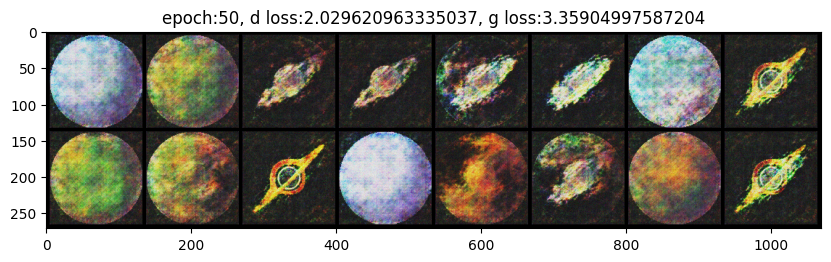

epoch:51, d loss:2.2139142215251923, g loss:3.4322567105293276, fid:208.0967254638672
epoch:52, d loss:2.071990931034088, g loss:3.297296237945557, fid:230.5647735595703
epoch:53, d loss:2.075872665643692, g loss:3.4255913138389587, fid:229.27078247070312
epoch:54, d loss:2.123384302854538, g loss:3.441142129898071, fid:237.56565856933594
epoch:55, d loss:2.1089364767074583, g loss:3.353238421678543, fid:217.3187713623047
epoch:56, d loss:2.119902342557907, g loss:3.5759828209877016, fid:229.187744140625
epoch:57, d loss:2.0477451145648957, g loss:3.3774893403053285, fid:240.93740844726562
epoch:58, d loss:2.0301531076431276, g loss:3.46504921913147, fid:231.27566528320312
epoch:59, d loss:2.022173970937729, g loss:3.5015699088573458, fid:263.57659912109375
epoch:60, d loss:2.00466051697731, g loss:3.5344751954078673, fid:235.46990966796875
epoch:61, d loss:2.0045303225517275, g loss:3.9868094682693482, fid:236.6743621826172
epoch:62, d loss:2.00138943195343, g loss:3.717144179344177, 

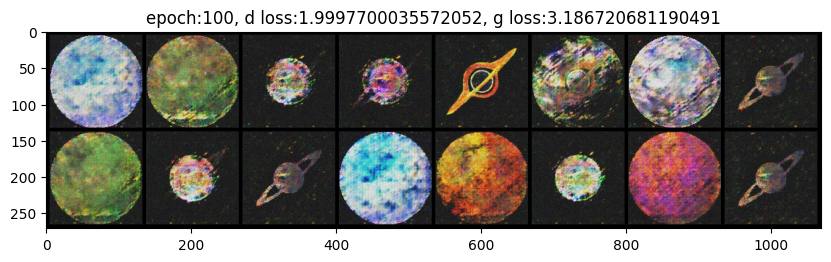

epoch:101, d loss:1.9599483549594878, g loss:3.25323668718338, fid:225.19427490234375
epoch:102, d loss:1.9331867754459382, g loss:3.5622460722923277, fid:219.09519958496094
epoch:103, d loss:1.9493368923664094, g loss:3.3886954545974732, fid:219.65895080566406
epoch:104, d loss:1.964981782436371, g loss:3.2837818264961243, fid:228.9942626953125
epoch:105, d loss:1.9623226702213288, g loss:3.3528796553611757, fid:245.18084716796875
epoch:106, d loss:1.9734194934368134, g loss:3.098934602737427, fid:234.28553771972656
epoch:107, d loss:2.0067552864551543, g loss:3.107965910434723, fid:222.78314208984375
epoch:108, d loss:1.9428252458572388, g loss:3.2646740436553956, fid:225.9714813232422
epoch:109, d loss:1.965753722190857, g loss:3.256254053115845, fid:226.46487426757812
epoch:110, d loss:1.9729928433895112, g loss:3.285009300708771, fid:217.49932861328125
epoch:111, d loss:1.9755105376243591, g loss:3.2021448493003843, fid:220.14059448242188
epoch:112, d loss:2.009155684709549, g los

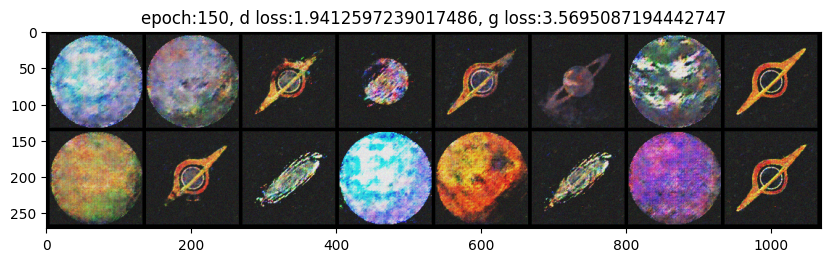

epoch:151, d loss:1.943904322385788, g loss:3.650220513343811, fid:232.80409240722656
epoch:152, d loss:1.9522397100925446, g loss:3.6386823415756226, fid:223.21446228027344
epoch:153, d loss:1.9374743819236755, g loss:3.7049060702323913, fid:224.2239990234375
epoch:154, d loss:1.9285129368305207, g loss:3.828693950176239, fid:208.31826782226562
epoch:155, d loss:1.951237577199936, g loss:3.6616450190544128, fid:212.84446716308594
epoch:156, d loss:1.9485502362251281, g loss:3.6387561321258546, fid:221.26173400878906
epoch:157, d loss:1.9492888033390046, g loss:3.654355597496033, fid:216.29920959472656
epoch:158, d loss:1.9767712235450745, g loss:3.8177727341651915, fid:215.9056396484375
epoch:159, d loss:1.9540234684944153, g loss:3.6060614466667174, fid:216.462646484375
epoch:160, d loss:1.973081934452057, g loss:3.7159091591835023, fid:222.1695556640625
epoch:161, d loss:1.9748465180397035, g loss:3.771199178695679, fid:235.4954071044922
epoch:162, d loss:2.0014133870601656, g loss:

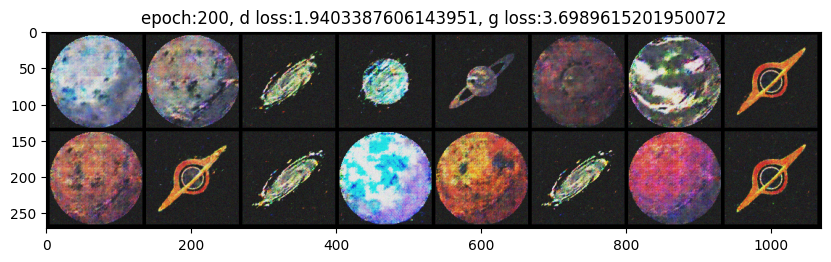

epoch:201, d loss:1.9151889204978942, g loss:3.7586047291755675, fid:217.43682861328125
epoch:202, d loss:1.9141268610954285, g loss:3.588794219493866, fid:218.55772399902344
epoch:203, d loss:1.9086977005004884, g loss:3.6839349627494813, fid:218.68209838867188
epoch:204, d loss:1.9105883359909057, g loss:3.6640076994895936, fid:215.505859375
epoch:205, d loss:1.9087612271308898, g loss:3.7092554330825807, fid:220.78781127929688
epoch:206, d loss:1.9186356663703918, g loss:3.6345167636871336, fid:218.6290283203125
epoch:207, d loss:1.9100923657417297, g loss:3.835974657535553, fid:223.4556121826172
epoch:208, d loss:1.9321118593215942, g loss:3.5527634739875795, fid:229.7978973388672
epoch:209, d loss:1.9140692174434661, g loss:3.6239019870758056, fid:224.36703491210938
epoch:210, d loss:1.9077942967414856, g loss:3.825937473773956, fid:220.71156311035156
epoch:211, d loss:1.905327355861664, g loss:3.7827351212501528, fid:221.84625244140625
epoch:212, d loss:1.906242698431015, g loss:

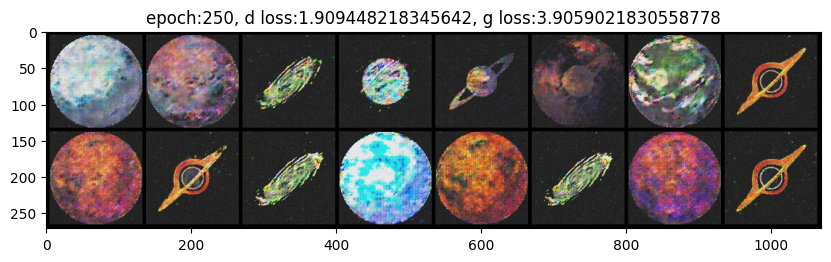

epoch:251, d loss:1.9049481749534607, g loss:3.900364363193512, fid:213.3267059326172
epoch:252, d loss:1.9382617056369782, g loss:3.87897527217865, fid:209.21798706054688
epoch:253, d loss:1.9369538366794585, g loss:3.7620616436004637, fid:222.3935546875
epoch:254, d loss:1.8995318710803986, g loss:4.122438132762909, fid:210.90158081054688
epoch:255, d loss:1.9002079963684082, g loss:3.9647151827812195, fid:212.5815887451172
epoch:256, d loss:1.9082927942276, g loss:3.925064408779144, fid:207.81436157226562
epoch:257, d loss:1.9098893642425536, g loss:3.8748139262199404, fid:212.65769958496094
epoch:258, d loss:1.9089184641838073, g loss:3.846918594837189, fid:212.8990936279297
epoch:259, d loss:1.900655496120453, g loss:4.0868500709533695, fid:214.46185302734375
epoch:260, d loss:1.9016773581504822, g loss:3.8999247550964355, fid:209.51502990722656
epoch:261, d loss:1.9000492215156555, g loss:3.998436999320984, fid:203.63446044921875
epoch:262, d loss:1.9071175515651704, g loss:3.902

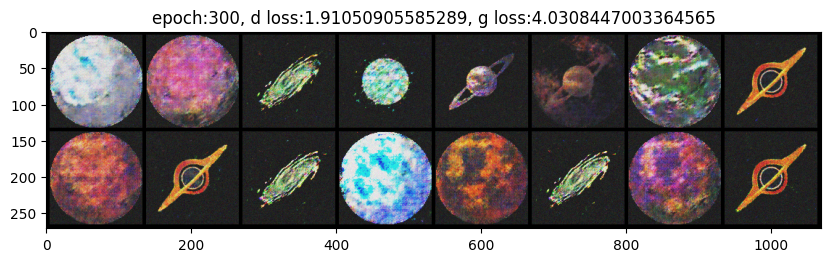

epoch:301, d loss:1.899335891008377, g loss:4.2966579556465145, fid:211.36209106445312
epoch:302, d loss:1.9120937824249267, g loss:4.001736295223236, fid:226.27102661132812
epoch:303, d loss:1.8962207674980163, g loss:4.242383968830109, fid:208.8295440673828
epoch:304, d loss:1.8961443781852723, g loss:4.171549308300018, fid:207.64862060546875
epoch:305, d loss:1.9135854840278625, g loss:3.7656808733940124, fid:210.84608459472656
epoch:306, d loss:1.9063012659549714, g loss:4.013855183124543, fid:201.9524383544922
epoch:307, d loss:1.9015863597393037, g loss:4.0717610836029055, fid:205.55287170410156
epoch:308, d loss:1.9117810130119324, g loss:4.045321524143219, fid:212.8875274658203
epoch:309, d loss:1.9047402501106263, g loss:4.018846106529236, fid:195.31678771972656
epoch:310, d loss:1.8988838732242583, g loss:4.1584094047546385, fid:194.41116333007812
epoch:311, d loss:1.9170526266098022, g loss:3.9314993143081667, fid:199.36500549316406
epoch:312, d loss:1.8985142588615418, g lo

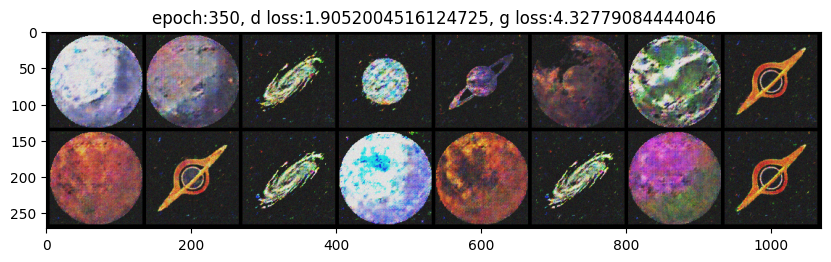

epoch:351, d loss:1.8913211882114411, g loss:4.450650537014008, fid:210.53622436523438
epoch:352, d loss:1.9051171720027924, g loss:4.301488089561462, fid:207.11180114746094
epoch:353, d loss:1.9147881507873534, g loss:4.199099278450012, fid:201.3191375732422
epoch:354, d loss:1.8967695653438568, g loss:4.43105161190033, fid:201.818115234375
epoch:355, d loss:1.9012510478496552, g loss:4.29691401720047, fid:206.02639770507812
epoch:356, d loss:1.9022947788238525, g loss:4.319060587882996, fid:206.74765014648438
epoch:357, d loss:1.8893784165382386, g loss:4.5195006966590885, fid:206.83694458007812
epoch:358, d loss:1.898665428161621, g loss:4.3368425369262695, fid:209.12428283691406
epoch:359, d loss:1.9188488483428956, g loss:4.230633199214935, fid:209.82723999023438
epoch:360, d loss:1.9153943300247191, g loss:4.29947829246521, fid:205.71823120117188
epoch:361, d loss:1.900517201423645, g loss:4.238680076599121, fid:209.89385986328125
epoch:362, d loss:1.898540484905243, g loss:4.413

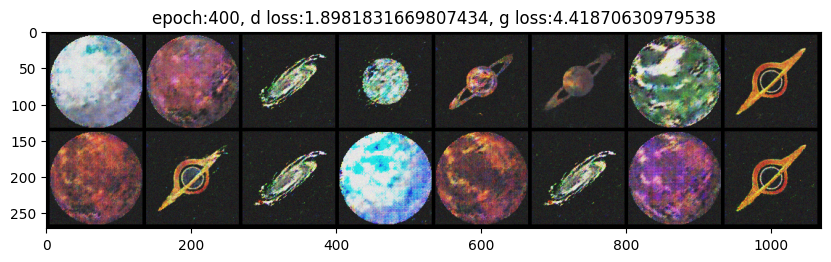

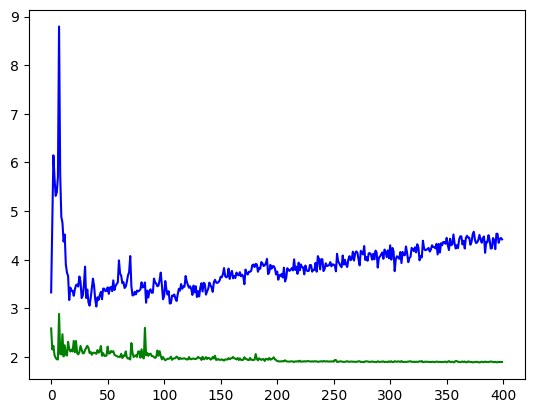

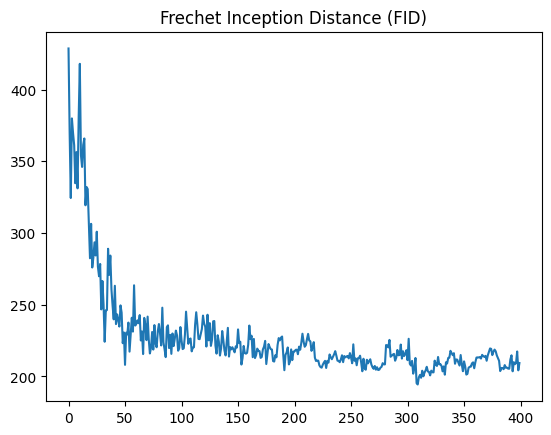

In [11]:
all_d_loss, all_g_loss, all_fid_score = [], [], []
rnd = random.uniform(0, 0.2)
for e in range(1, 401):
    if e == 100:
        change_lr(g_optim, 1e-4)
        change_lr(d_optim, 1e-4)
        rnd = random.uniform(0, 0.1)
    if e == 200:
        change_lr(g_optim, 2e-5)
        change_lr(d_optim, 2e-5)
        rnd = random.uniform(0, 0.05)

    d_loss, g_loss = train((D, G), data_loader, (d_optim, g_optim), loss_fn, class_loss_fn, rnd)
    all_d_loss.append(d_loss)
    all_g_loss.append(g_loss)

    fid_score = eval(G, eval_data_loader, fid)
    all_fid_score.append(fid_score.cpu())
    print(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}, fid:{fid_score}')
    if e % 50 == 0:
        plot_examples(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')

plt.plot(all_d_loss, color='green')
plt.plot(all_g_loss, color='blue')
plt.show()

plt.plot(all_fid_score)
plt.title('Frechet Inception Distance (FID)')
plt.show()

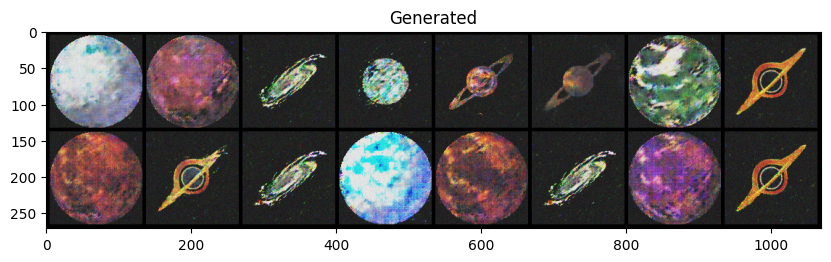

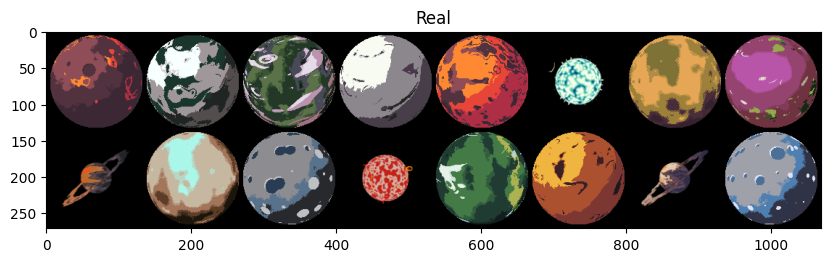

In [12]:
plot_examples('Generated')
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(vutils.make_grid(next(iter(data_loader))[0][:16], padding=5, normalize=True), (1, 2, 0)))
plt.title('Real')
plt.show()